### What we will learn
- How to read multiple satellite images
- How to specify the location on a numpy array from a geographic coordinate of a point.
- How to show a time-series change of NDVI at a specific location

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
from shapely.geometry import Point
import json
import pycrs
import os
import folium

We're going to use a series of sentinel-2 images at different dates. "os.listdir()" shows us what files are inside a directory.

In [5]:
listOfFileNames=os.listdir("C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image_timeSeries")
listOfFileNames

['sentinel2_2020-01-03.tif',
 'sentinel2_2020-04-02.tif',
 'sentinel2_2020-05-17.tif',
 'sentinel2_2020-08-15.tif',
 'sentinel2_2020-11-28.tif',
 'sentinel2_2021-01-02.tif',
 'sentinel2_2021-03-03.tif']

There are seven files inside the directory. Let's check the metadata and show one of the image.

In [6]:
opened=rasterio.open("C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image_timeSeries\sentinel2_2020-08-15.tif")

In [7]:
opened.meta #The resolution is set to 10 m.

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 9173,
 'height': 4538,
 'count': 7,
 'crs': CRS.from_epsg(32654),
 'transform': Affine(10.0, 0.0, 315390.0,
        0.0, -10.0, 3967010.0)}

In [8]:
opened.descriptions #There are seven available bands.

('B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12')

In [9]:
red=opened.read(3)
green=opened.read(2)
blue=opened.read(1)

factor=3*np.mean(red)

rgb=np.dstack((red,green,blue))/factor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


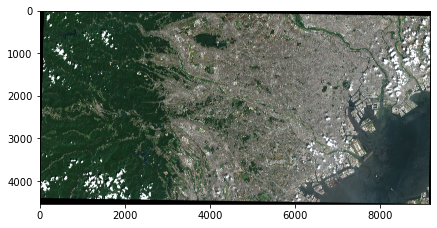

In [25]:
plt.figure(figsize=(7, 7))
plt.imshow(rgb)

The image is too large to handle at once, so let's clip images by ROI and save them in geotiff files. We will use the same ROI that we used in the 3rd introduction to satellite image analysis with python.

In [11]:
ROI=box(139.65,35.63,139.86,35.73)
geo = gpd.GeoDataFrame({'geometry': ROI}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs=opened.crs)
coords=[json.loads(geo.to_json())['features'][0]['geometry']]

C:\Users\shoki\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
map=folium.Map([35.65,139.7],zoom_start=11)
folium.GeoJson(ROI).add_to(map)
map

However, we have seven images to process. Therefore, it's time-consuming to apply operations on them manually. So we will define a function that does the job instead of us. Before defining the function, I'd like to explain about an useful method called "f-string". "f-string" is used to include a variable inside a string. It's very much helpful when we want to change the path to the image depending on the input values. An example of the "f-string" is shown below.

**How to use "f-string"**<br>
f"{variable's name}"

In [13]:
#An example of "f-string"
#The numbers from 0 to 4 are substituted inside the blacket.
for i in range(5):
    print(f"The number is {i}.")

The number is 0.
The number is 1.
The number is 2.
The number is 3.
The number is 4.


In [14]:
def clipImage(image_path,coords,outputPath,fileName):
    opened_img=rasterio.open(f"{image_path}")
    out_img, out_transform = rasterio.mask.mask(opened_img, coords, crop=True)
    
    driver=opened_img.meta["driver"]
    width=out_img[0].shape[1] #Set the number of columns to match the clipped image.
    height=out_img[0].shape[0] #Set the number of rows to match the clipped image.
    count=opened_img.meta["count"] #Set the number of bands as 4 since we only use B2, B3, B4, and B8.
    crs=opened_img.meta["crs"]
    transform=out_transform #The affine transformation is the one we've gotten from mask module.
    dtype=out_img.dtype
    
    fileName=fileName.replace(".tif","") #Extract only the name of the image.
    fileName_mod=fileName+"_clipped.tif" #Add a suffix to indicate that the image is clipped.
    
    with rasterio.open(outputPath+f"\{fileName_mod}",
                   'w',
                  driver=driver,
                  width=width,
                  height=height,
                  count=count,
                  crs=crs,
                  transform=transform,
                  dtype=dtype) as output:
        for i in range(count): #Read bands by looping.
            output.write(out_img[i],i+1)
        output.close()

To read multiple images in a directory, the loop operation is very much helpful. We will apply the function we created above on all the sentinel-2 images inside the directory.

In [16]:
#I created a new directory to store output images.
directoryPath="C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image_timeSeries"
outputPath="C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image_timeseries_clipped"
for fileName in listOfFileNames:
    imagePath=directoryPath+f"\{fileName}"
    clipImage(imagePath,coords,outputPath,fileName)

The output images inside the directry.

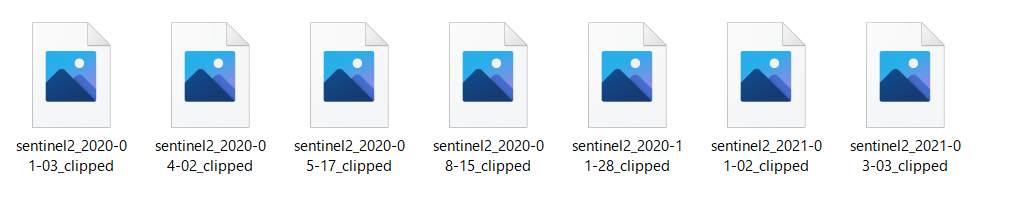

We're going to extract the spectral information in the images. First, we will convert a lat/long coordinate into an UTM coordinate which is an original CRS of the sentinel-2 images. After that, we're goint to give rasterio that information. Then rasterio tells us the matrix coordinate of the point.

In [17]:
#Define a coordinate of a point where we want to look into.
#In this example, the point is in the Komaba-park.
point=(35.6615,139.6809)
map=folium.Map([35.6615,139.6809],zoom_start=17)
folium.Marker(point).add_to(map)
map

In [18]:
#Calculate a UTM coordinate from the lat/long values.
#We need to prepare the transformation operaters first.
#These codes get the necessary information from the metadata of the file.
proj=((Proj(f"{opened.crs}").definition_string()).split()[0]).replace("proj=","")
zone=int(((Proj(f"{opened.crs}").definition_string()).split()[1]).replace("zone=",""))
ellps=((Proj(f"{opened.crs}").definition_string()).split()[2]).replace("datum=","")

#The transformation operater
p=Proj(proj=proj,zone=zone,ellps=ellps, preserve_units=False)

#Calculate a UTM coordinate.
UTMx,UTMy=p(point[1],point[0])

By giving the UTM coordinates to rasterio, we'll be able to know the matrix coordinate of the point.

In [19]:
opened_clipped=rasterio.open("C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image_timeseries_clipped\sentinel2_2020-08-15_clipped.tif")
column,row=opened_clipped.index(UTMx,UTMy)

Let's read and show the spectrm characteristics at the point! To do that job, we'll use the loop. 

In [20]:
opened_array=opened_clipped.read()*0.0001 #Convert to reflectance by multipling a factor.

spectrum_values=[] #An empty list to store the values.
for i in range(7):
    reflectance=opened_array[i][column,row]
    spectrum_values.append(reflectance)

Text(0, 0.5, 'reflectance')

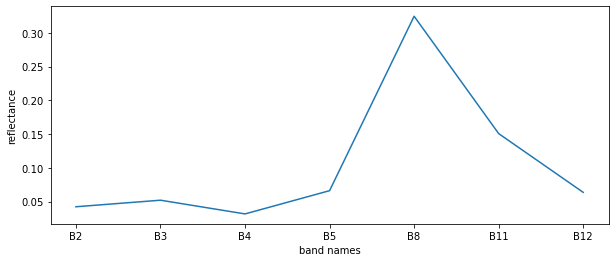

In [21]:
#Show the spectrum curve
#The point is located in the vegetated area, so the curve shows a high-reflectance in the near-infrared region.
bandNames=opened.descriptions
fig=plt.figure(figsize=(10,4))
ax=fig.subplots()
ax.plot(bandNames,spectrum_values)
ax.set_xlabel("band names")
ax.set_ylabel("reflectance")

We've learned how to extract spectral characteristics from an image. The next step is to see the time series change of the NDVI values at the location. We define a function that calculate a NDVI value and returns it.

In [22]:
def NDVI_calculator(data,column,row):
    nir=data.read(5)[column,row] #The reflectance value at the point in Band 8
    red=data.read(4)[column,row] #he reflectance value at the point in Band 4
    ndvi=(nir-red)/(nir+red) #Calculate a NDVI value
    return ndvi    

Apply the function on all the sentinel-2 image by using a loop operation. The calculated NDVI values will be stored in a list.

In [23]:
NDVI_timeseries=[]
directoryPath="C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image_timeSeries_clipped"
listOfFileNames=os.listdir(directoryPath)

for fileName in listOfFileNames:
    imagePath=directoryPath+f"\{fileName}"
    image=rasterio.open(imagePath)
    ndvi=NDVI_calculator(image,column,row)
    NDVI_timeseries.append(ndvi)

Text(0, 0.5, 'ndvi')

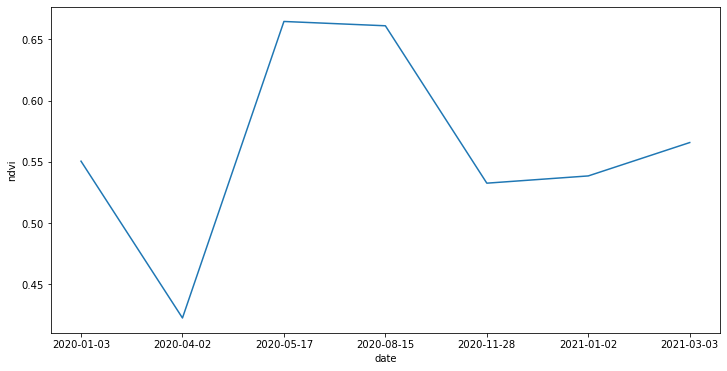

In [24]:
date=["2020-01-03","2020-04-02","2020-05-17","2020-08-15","2020-11-28","2021-01-02","2021-03-03"]
fig=plt.figure(figsize=(12,6))
ax=fig.subplots()
ax.plot(date,NDVI_timeseries)
ax.set_xlabel("date")
ax.set_ylabel("ndvi")

We can see that NDVI values are low in winter, while they are high in summer.